In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
signal_trees = TreeIter(list(map(Tree,fc.eightb.accstudies_no_pu.signal_list)))
signal_trees_pu = TreeIter(list(map(Tree,fc.eightb.accstudies.signal_list)))

# signal_trees.extend(kwargs=lambda tree : dict(n_ext_jet=tree.n_jet-tree.nfound_presel))
# signal_trees.extend(kwargs=eightb.reco_all)
# signal_trees.extend(kwargs=eightb.reco_res_all)

In [3]:
all_trees = TreeIter(list(signal_trees)+list(signal_trees_pu))

In [4]:
def get_point(label):
    label = label.split('_')
    return str((int(label[1]),int(label[3])))
signal_points = list(map(get_point,signal_trees.sample))

In [5]:
dout = "trigger/"

tree = signal_trees[-2]
tree_pu = signal_trees_pu[-2]

In [6]:
varinfo.clear()

In [7]:
trigger = 'HLT_PFHT330PT30_QuadPFJet_75_60_45_40_TriplePFBTagDeepCSV_4p5'

In [8]:
trigger_trees = EventFilter('trigger',**{trigger:1}).filter(signal_trees)

In [12]:
all_trees.extend(kwargs=lambda t : dict(
    pass_8jetpt20=ak.sum((t.jet_pt>20) ,axis=-1)>=8,
    pass_8jetgood=ak.sum( (np.abs(t.jet_eta)<2.5) & (t.jet_pt>20),axis=-1)>=8,
));

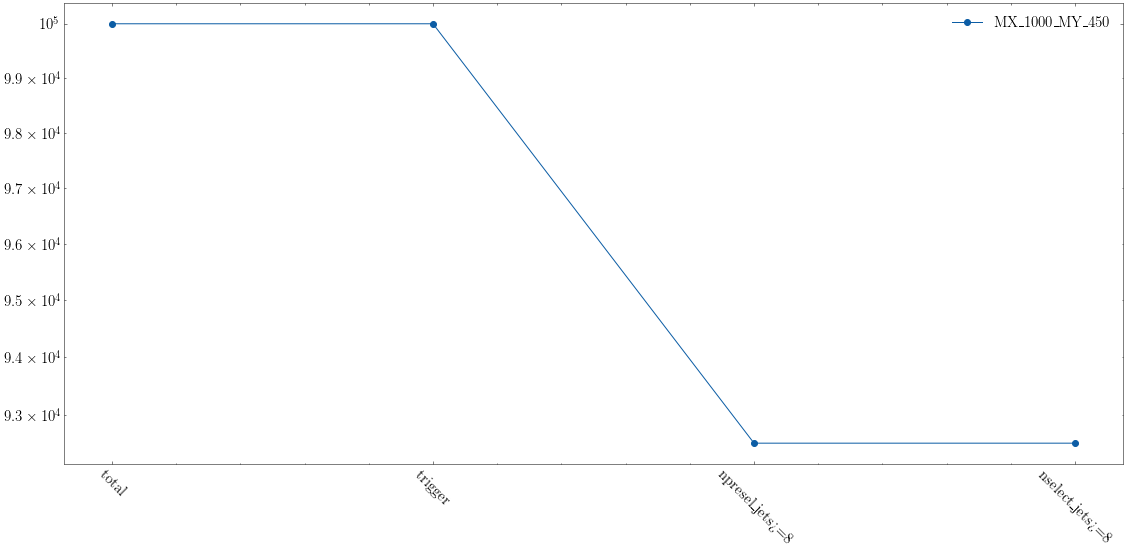

In [10]:
study.cutflow([tree])

In [36]:
def calc_8jet_efficiency(tree,*masks,operator=lambda m,n : m & n):
    masks = [ tree[mask] for mask in masks ]
    full_mask = masks[0]
    for mask in masks[1:]:
        full_mask = operator(full_mask,mask)
    return ak.sum(full_mask)/ak.count(full_mask)

In [50]:
def mask_comparision(mask_i,mask_j):
    masks = [(mask_i,mask_i),(mask_j,mask_j),(mask_i,mask_j)]
    fig,axs = plt.subplots(ncols=3,figsize=(16,5))
    for i,(mask_i,mask_j) in enumerate(masks):
        if mask_i == mask_j: mask = mask_i 
        else: mask = f"{mask_i} \& {mask_j}"
        mask = mask.replace(trigger,"trigger")
        efficiency = signal_trees.apply(lambda t : calc_8jet_efficiency(t,mask_i,mask_j) )
        efficiency_pu = signal_trees_pu.apply(lambda t : calc_8jet_efficiency(t,mask_i,mask_j) )
        graph_multi(signal_points,[efficiency,efficiency_pu],labels=["No PU","With PU"],title=mask,ylabel=mask,xlabel=signal_points,ylim=(0.50,1.0),grid=True,figax=(fig,axs[i]))
    fig.tight_layout()

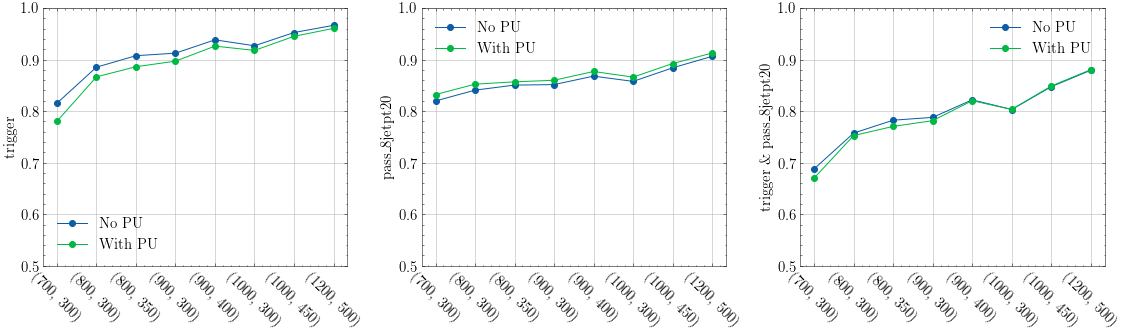

In [51]:
mask_comparision(trigger,'pass_8jetpt20')

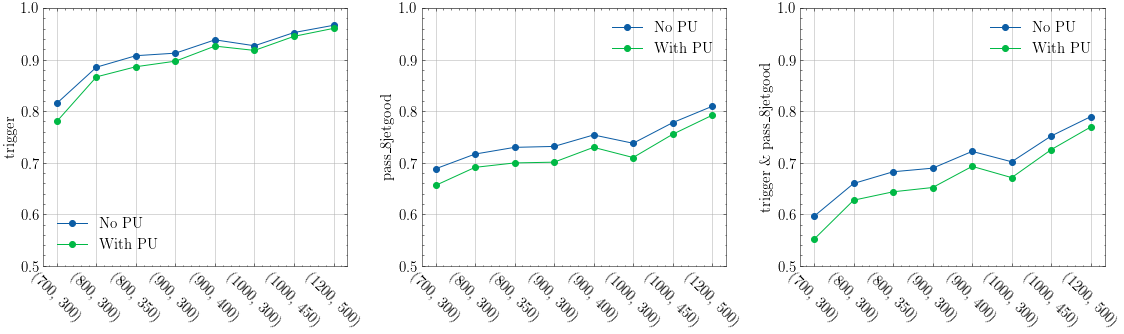

In [52]:
mask_comparision(trigger,'pass_8jetgood')

In [54]:
all_trees.extend(kwargs = lambda t : build_collection(t,'gen_H\dY\d_b\d','gen_quark'));

In [56]:
all_trees.extend(kwargs = eightb.reco_all);

In [67]:
all_trees.extend(kwargs = lambda t : build_collection(t,'gen_H\dY\d','gen_higgs'))

In [73]:
all_trees.extend(kwargs = lambda t : build_collection(t,'gen_Y\d','gen_ys'))

In [70]:
def get_mask_list(tree,mask_i,mask_j,return_names=False):
    masks = [tree.all_events_mask,tree[mask_i] == 1,tree[mask_j] == 1]
    masks.append(masks[1] & masks[2])
    mask_i = mask_i.replace(trigger,'trigger')
    mask_j = mask_j.replace(trigger,'trigger')
    names = ['all events',mask_i,mask_j,f'{mask_i} \& {mask_j}']
    if return_names: return masks,names
    return masks

In [79]:
def kinematic_comparison(tree,mask_i,mask_j,show=['jets','higgs','ys','x']):
    masks,names = get_mask_list(tree,mask_i,mask_j,True)
    study_kwargs = dict(
        s_colors=None,
        labels=names,
        scale=False,
        ratio=True,
        r_size='60%',
        r_inv=True,
        r_ylim=(0.45, 1.1),
        dim=(-1, 4),)
    
    if 'jets' in show:
        jet_vars = ['ptRegressed','eta','phi','btag']
        varlist = [f'gen_quark_recojet_{var}' for var in jet_vars]
        study.quick(
            [tree,tree,tree,tree],
            masks=[ (tree['gen_quark_recojet_pt'] > 0) & mask for mask in masks ],
            varlist=varlist,
            **study_kwargs
        )
        
    if 'higgs' in show:
        higgs_vars = ['pt','eta','phi','m']
        varlist = [f'gen_higgs_reco_{var}' for var in higgs_vars]
        study.quick(
            [tree,tree,tree,tree],
            masks=[ (tree['gen_higgs_reco_matched'] == 1) & mask for mask in masks ],
            varlist=varlist,
            **study_kwargs
        )
        
    if 'ys' in show:
        higgs_vars = ['pt','eta','phi','m']
        varlist = [f'gen_ys_reco_{var}' for var in higgs_vars]
        study.quick(
            [tree,tree,tree,tree],
            masks=[ (tree['gen_ys_reco_matched'] == 1) & mask for mask in masks ],
            varlist=varlist,
            **study_kwargs
        )
        
    if 'x' in show:
        higgs_vars = ['pt','eta','phi','m']
        varlist = [f'gen_X_reco_{var}' for var in higgs_vars]
        study.quick(
            [tree,tree,tree,tree],
            masks=[ (tree['gen_X_reco_matched'] == 1) & mask for mask in masks ],
            varlist=varlist,
            **study_kwargs
        )

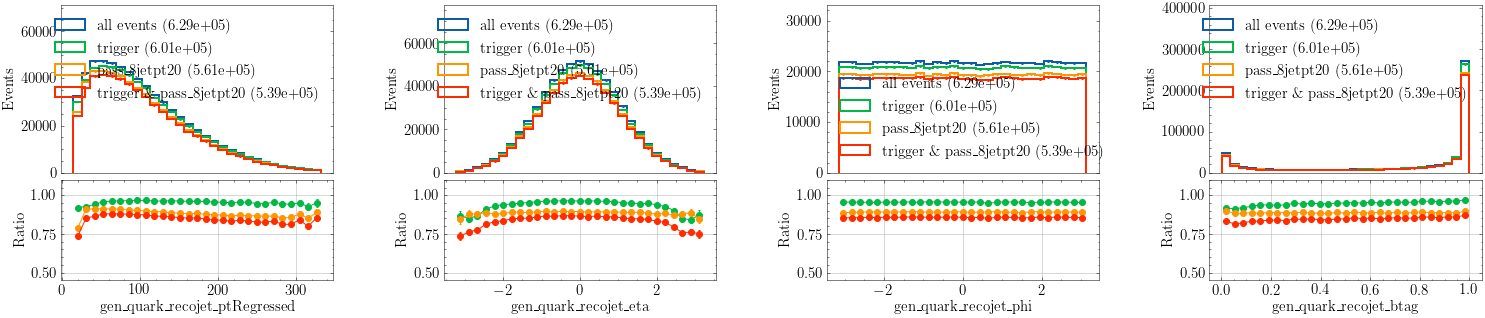

In [80]:
kinematic_comparison(tree,trigger,'pass_8jetpt20',show=['jets'])

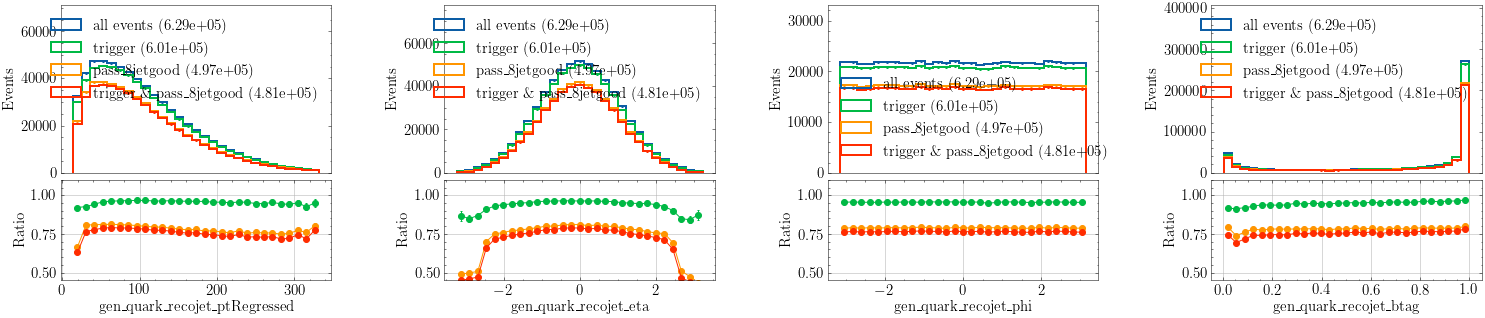

In [81]:
kinematic_comparison(tree,trigger,'pass_8jetgood',show=['jets'])